In [11]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

# Also tried:
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.applications import VGG19
# from tensorflow.keras.applications import Inception_V3

In [4]:
# 6 classes to predict
NUM_CLASSES = 6

# RGB Channel
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OPTIMIZER = Adam(lr=0.001)
OBJECTIVE_FUNCTION = 'categorical_crossentropy'
LOSS_METRICS = ['accuracy']

# Also tested 4, 8 and 16 batches
BATCH_SIZE_TRAINING = 16
BATCH_SIZE_VALIDATION = 16
BATCH_SIZE_TEST = 16
EPOCHS = 20

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [5]:
# Compose model
model = Sequential()

model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Set first layer not to train because (ResNet) model is already trained
model.layers[0].trainable = False

# Also tried a bit fine-tuning but the results were not so good:
# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
""" 
Also tried a bit fine-tuning but the results were not so good:
1st try:
model = Sequential()
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

---------------------------------------------------------------------------------------------------

2nd try:
pre_trained_model = ResNet50(include_top = False, weights = 'imagenet')

for layer in pre_trained_model.layers:
     layer.trainable = False
     last_layer = pre_trained_model.get_layer('conv5_block3_out')

last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(6, activation='softmax')(x)

model = Model(pre_trained_model.input, x) 
"""

In [6]:
# preprocessing_function is applied on each image but only after re-sizing & augmentation (resize => augment => pre-process)
# Each of the keras.application.resnet* preprocess_input MOSTLY mean BATCH NORMALIZATION (applied on each batch) stabilize the inputs to nonlinear activation functions
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# flow_From_directory generates batches of augmented data (where augmentation can be color conversion, etc)
train_generator = data_generator.flow_from_directory(
    '/content/drive/MyDrive/eigene_Blaettersammlung/train',
        target_size=(IMAGE_RESIZE, IMAGE_RESIZE),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        '/content/drive/MyDrive/eigene_Blaettersammlung/val',
        target_size=(IMAGE_RESIZE, IMAGE_RESIZE),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical') 

test_ds = data_generator.flow_from_directory(
        '/content/drive/MyDrive/eigene_Blaettersammlung/test',
        target_size=(IMAGE_RESIZE, IMAGE_RESIZE),
        batch_size=BATCH_SIZE_TEST,
        class_mode='categorical')

Found 1253 images belonging to 6 classes.
Found 156 images belonging to 6 classes.
Found 159 images belonging to 6 classes.


In [9]:
# Model development ends when loss does not improve after 5 epochs
from tensorflow import keras

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
)

In [10]:
# Run model
model.compile(optimizer=OPTIMIZER, loss=OBJECTIVE_FUNCTION, metrics=LOSS_METRICS)

history = model.fit(train_generator, validation_data=validation_generator, callbacks=[early_stopping], epochs=EPOCHS)

Epoch 1/20
79/79 [==============================] - 598s 7s/step - loss: 0.6063 - accuracy: 0.8300 - val_loss: 0.2830 - val_accuracy: 0.9231
Epoch 2/20
79/79 [==============================] - 163s 2s/step - loss: 0.1060 - accuracy: 0.9904 - val_loss: 0.1664 - val_accuracy: 0.9679
Epoch 3/20
79/79 [==============================] - 163s 2s/step - loss: 0.0629 - accuracy: 0.9936 - val_loss: 0.1800 - val_accuracy: 0.9167
Epoch 4/20
79/79 [==============================] - 163s 2s/step - loss: 0.0388 - accuracy: 0.9976 - val_loss: 0.1266 - val_accuracy: 0.9615
Epoch 5/20
79/79 [==============================] - 161s 2s/step - loss: 0.0274 - accuracy: 0.9992 - val_loss: 0.1397 - val_accuracy: 0.9487
Epoch 6/20
79/79 [==============================] - 160s 2s/step - loss: 0.0211 - accuracy: 0.9992 - val_loss: 0.1105 - val_accuracy: 0.9615
Epoch 7/20
79/79 [==============================] - 160s 2s/step - loss: 0.0164 - accuracy: 1.0000 - val_loss: 0.1197 - val_accuracy: 0.9487
Epoch 8/20
79

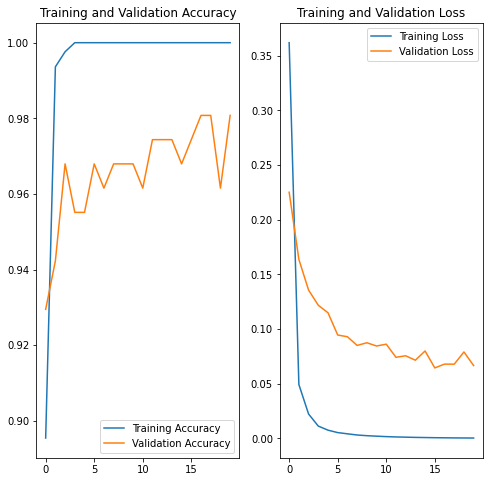

In [ ]:
# Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
# Model evaluation
model.evaluate(test_ds)

10/10 [==============================] - 68s 7s/step - loss: 0.1360 - accuracy: 0.9497


[0.1359800100326538, 0.9496855139732361]

In [13]:
# Save Model
model.save('resNet50_16_new.h5')